In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(tf.__version__)

2.18.0


In [3]:
dataset_train = pd.read_csv("Google_Stock_Price_Train.csv")
training_set =  dataset_train.iloc[:, 1:2].values
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
# Creating data structure with 60 timestamps and 1 output
X_train = []
y_train = []

for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])

# Convert to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)
# index_0 = X_train.shape[0] # num rows
# index_1 = X_train.shape[1] # num columns

# Reshape the array to add another dimension as a predictor for our stock prices
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [12]:
regressor = Sequential()
# first LSTM layer
regressor.add(LSTM(units=70, # num neurons
                   return_sequences=True, # pass the output to the next layer
                   input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(rate=0.2))
# second LSTM layer
regressor.add(LSTM(units=70, return_sequences=True))
regressor.add(Dropout(rate=0.2))
# third LSTM layer
regressor.add(LSTM(units=70,return_sequences=True))
regressor.add(Dropout(rate=0.2))
# fourth LSTM layer
regressor.add(LSTM(units=70,return_sequences=True))
regressor.add(Dropout(rate=0.2))
# fifth LSTM layer
regressor.add(LSTM(units=70,return_sequences=False))
regressor.add(Dropout(rate=0.2))
# Add a the final layer which is a fully connected layer
regressor.add(Dense(units=1))

# Compile the RNN supplying the Optimizer and the Loss function
# We will use ADAM as the optimizer, but there are others like RMSProp or NADAM
# Ref: Keras docs on RNN for more..
regressor.compile(optimizer="adam", loss="mean_squared_error") # MSE is good for regression=Sequential data

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0873
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0067
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0058
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0047
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0048
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0046
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0061
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0039
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0047
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0046
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0042
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0043
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0038
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

In [14]:
# Predictions test
dataset_test = pd.read_csv("Google_Stock_Price_Test.csv")
real_stock_price = dataset_test.iloc[:, 1:2].values

In [15]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60 :].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [16]:
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [17]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


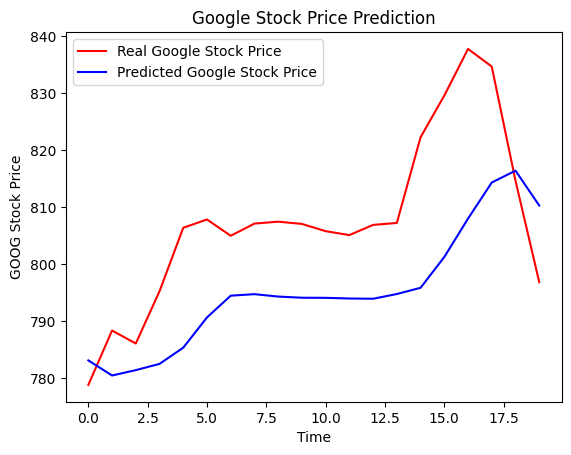

In [18]:
import matplotlib.pyplot as plt
plt.plot(real_stock_price, color="red", label="Real Google Stock Price", )
plt.plot(predicted_stock_price, color="blue", label="Predicted Google Stock Price")

plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("GOOG Stock Price")
plt.legend()
plt.show()